# Linear regression


In [0]:
import statsmodels
import scipy as sc
import numpy as np
import pandas as pd

import statsmodels.formula.api as smf
import statsmodels.stats.api as sms

import matplotlib.pyplot as plt

from statsmodels.graphics.regressionplots import plot_leverage_resid2

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Data


Let's analyze a survey of 4361 women from Botswana:

* how many children did she give birth to (ceb sign)
* age
* duration of education (educ)
* religious affiliation
* ideal, in her opinion, the number of children in the family (idlnchld)
* was she ever married (evermarr)
* age of first marriage (agefm)
* duration of education by husband (heduc)
* Does she know about contraceptive methods (knowmeth)
* Does she use contraceptive methods (usemeth)
* Does she live in the city (urban)
* does she have electricity, radio, tv and bicycle (electric, radio, tv, bicycle)

Let's learn how to estimate the number of ceb children by other signs.

Download the data and study it carefully.

Data:

In [0]:
botswana = pd.read_csv("https://raw.githubusercontent.com/OzmundSedler/100-Days-Of-ML-Code/master/week_12/datasets/botswana.tsv", sep="\t", index_col=False) 

In [7]:
botswana.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4361 entries, 0 to 4360
Data columns (total 15 columns):
ceb         4361 non-null int64
age         4361 non-null int64
educ        4361 non-null int64
religion    4361 non-null object
idlnchld    4241 non-null float64
knowmeth    4354 non-null float64
usemeth     4290 non-null float64
evermarr    4361 non-null int64
agefm       2079 non-null float64
heduc       1956 non-null float64
urban       4361 non-null int64
electric    4358 non-null float64
radio       4359 non-null float64
tv          4359 non-null float64
bicycle     4358 non-null float64
dtypes: float64(9), int64(5), object(1)
memory usage: 511.1+ KB


In [8]:
botswana.head()

,ceb,age,educ,religion,idlnchld,knowmeth,usemeth,evermarr,agefm,heduc,urban,electric,radio,tv,bicycle
0,0,18,10,catholic,4.0,1.0,1.0,0,NaN,NaN,1,1.0,1.0,1.0,1.0
1,2,43,11,protestant,2.0,1.0,1.0,1,20.0,14.0,1,1.0,1.0,1.0,1.0
2,0,49,4,spirit,4.0,1.0,0.0,1,22.0,1.0,1,1.0,1.0,0.0,0.0
3,0,24,12,other,2.0,1.0,0.0,0,NaN,NaN,1,1.0,1.0,1.0,1.0
4,3,32,13,other,3.0,1.0,1.0,1,24.0,12.0,1,1.0,1.0,1.0,1.0


In [9]:
botswana.describe()

,ceb,age,educ,idlnchld,knowmeth,usemeth,evermarr,agefm,heduc,urban,electric,radio,tv,bicycle
count,4361.000000,4361.000000,4361.000000,4241.000000,4354.000000,4290.000000,4361.000000,2079.000000,1956.000000,4361.000000,4358.000000,4359.000000,4359.000000,4358.000000
mean,2.441642,27.405182,5.855996,4.615892,0.963252,0.577622,0.476726,20.686388,5.144683,0.516625,0.140202,0.701766,0.092911,0.275815
std,2.406861,8.685233,3.927075,2.219303,0.188164,0.493996,0.499515,5.002383,4.803028,0.499781,0.347236,0.457535,0.290341,0.446975
min,0.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,20.000000,3.000000,3.000000,1.000000,0.000000,0.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,26.000000,7.000000,4.000000,1.000000,1.000000,0.000000,20.000000,6.000000,1.000000,0.000000,1.000000,0.000000,0.000000
75%,4.000000,33.000000,8.000000,6.000000,1.000000,1.000000,1.000000,23.000000,8.000000,1.000000,0.000000,1.000000,0.000000,1.000000
max,13.000000,49.000000,20.000000,20.000000,1.000000,1.000000,1.000000,46.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000


 How many different values does the religion sign take?

In [10]:
print(botswana['religion'].unique())

['catholic' 'protestant' 'spirit' 'other']


Many signs have missing values. How many objects out of 4361 remain if you throw away all those containing gaps?

In [12]:
botswana.dropna().shape

(1834, 15)

For various reasons, omissions arise for various reasons and must be handled differently.

For example, in the agefm attribute, gaps are found only where evermarr = 0, that is, they correspond to women who have never married. Thus, for this attribute, NaN corresponds to the value "not applicable".

In such cases, when the sign x_1x
one
In principle, it cannot take any values on parts of objects, it is recommended to do so:

create a new binary tag:

x2 = 1, when x1 = 'not applicable'
otherwise x2 = 0;

Let's use this method to handle gaps in agefm and heduc.

Create a nevermarr attribute equal to one where there are gaps in agefm. Remove the evermarr sign - in total with nevermarr it gives a constant, which means that in our matrix X there will be multicollinearity. Replace NaN in agefm with cagefm = 0. For objects where nevermarr = 1, replace the NaN in the heduc attribute with cheduc1 = −1 (zero cannot be used, since it is already found in some objects of the sample). How many missing values remained in the heduc attribute?


In [0]:
botswana['nevermarr'] = [1 if botswana.loc[i, 'evermarr'] == 0 else 0 for i in range(botswana.shape[0])]

replace "not applicable" in x_1 to an arbitrary constant cc, which among other values x_1x not found.

In [14]:
np.unique(botswana.agefm[botswana.agefm.notnull()].values)

array([10., 11., 12., 13., 14., 15., 16., 17., 18., 19., 20., 21., 22.,
       23., 24., 25., 26., 27., 28., 29., 30., 31., 32., 33., 34., 35.,
       36., 37., 38., 39., 40., 41., 43., 44., 46.])

In [15]:
botswana.agefm[botswana.agefm.isnull()] = 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [16]:
botswana.head()

,ceb,age,educ,religion,idlnchld,knowmeth,usemeth,evermarr,agefm,heduc,urban,electric,radio,tv,bicycle,nevermarr
0,0,18,10,catholic,4.0,1.0,1.0,0,0.0,NaN,1,1.0,1.0,1.0,1.0,1
1,2,43,11,protestant,2.0,1.0,1.0,1,20.0,14.0,1,1.0,1.0,1.0,1.0,0
2,0,49,4,spirit,4.0,1.0,0.0,1,22.0,1.0,1,1.0,1.0,0.0,0.0,0
3,0,24,12,other,2.0,1.0,0.0,0,0.0,NaN,1,1.0,1.0,1.0,1.0,1
4,3,32,13,other,3.0,1.0,1.0,1,24.0,12.0,1,1.0,1.0,1.0,1.0,0


In [0]:
del botswana['evermarr']

In [18]:
botswana.heduc[botswana.heduc.isnull() & botswana.nevermarr.values == 1] = -1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


How many missing values remained in the heduc attribute?

In [19]:
botswana.heduc.isnull().value_counts()

False    4238
True      123
Name: heduc, dtype: int64

Get rid of the remaining passes.

For the idlnchld, heduc and usemeth signs, perform an operation similar to the previous one: create skip indicators for these signs (idlnchld_noans, heduc_noans, usemeth_noans), replace the gaps with uncharacteristic values (cidlnchld = −1, cheduc2 = −2 (we already used the value -1) , cusemeth = −1).

Only gaps remained in the signs of knowmeth, electric, radio, tv and bicycle. There are very few of them, so delete objects on which their values are missing.

What size is our data matrix now? Multiply the number of rows by the number of all columns (including ceb response).

In [0]:
botswana['idlnchld_noans'] = 0
botswana.loc[botswana.idlnchld.isnull(), 'idlnchld_noans'] = 1

botswana['heduc_noans'] = 0
botswana.loc[botswana.heduc.isnull(), 'heduc_noans'] = 1

botswana['usemeth_noans'] = 0
botswana.loc[botswana.usemeth.isnull(), 'usemeth_noans'] = 1

In [21]:
botswana.idlnchld[botswana.idlnchld.isnull()] = -1
botswana.heduc[botswana.heduc.isnull()] = -2
botswana.usemeth[botswana.usemeth.isnull()] = -1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [22]:
botswana.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4361 entries, 0 to 4360
Data columns (total 18 columns):
ceb               4361 non-null int64
age               4361 non-null int64
educ              4361 non-null int64
religion          4361 non-null object
idlnchld          4361 non-null float64
knowmeth          4354 non-null float64
usemeth           4361 non-null float64
agefm             4361 non-null float64
heduc             4361 non-null float64
urban             4361 non-null int64
electric          4358 non-null float64
radio             4359 non-null float64
tv                4359 non-null float64
bicycle           4358 non-null float64
nevermarr         4361 non-null int64
idlnchld_noans    4361 non-null int64
heduc_noans       4361 non-null int64
usemeth_noans     4361 non-null int64
dtypes: float64(9), int64(8), object(1)
memory usage: 613.3+ KB


In [0]:
botswana = botswana.dropna()

Build a regression of the number of ceb children on all available signs using the smf.ols method, as in the example before. What is the coefficient of determination R ^ 2R

In [24]:
formula = 'ceb ~ ' + ' + '.join(botswana.columns[1:])
m1 = smf.ols(formula, data=botswana)
fitted = m1.fit()

print (fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                    ceb   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     412.5
Date:                Sun, 08 Sep 2019   Prob (F-statistic):               0.00
Time:                        07:04:06   Log-Likelihood:                -7732.1
No. Observations:                4348   AIC:                         1.550e+04
Df Residuals:                    4328   BIC:                         1.563e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -1

Note that for the religion attribute, several binary dummy variables were automatically created in the model. How many of them?

In [25]:
print(botswana.religion.value_counts())

spirit        1838
other         1076
protestant     989
catholic       445
Name: religion, dtype: int64


Check the Broysch-Pagan criterion for the homoskedasticity of the error in the constructed model. Is it running?

If the error is heteroskedastic, reconfigure the model by correcting White type HC

In [27]:
print('Breusch-Pagan test: p=%f' % sms.het_breuschpagan(fitted.resid, fitted.model.exog)[1])

Breusch-Pagan test: p=0.000000


In [28]:
formula = 'ceb ~ ' + ' + '.join(botswana.columns[1:])
m2 = smf.ols(formula, data=botswana)
fitted_m2 = m1.fit(cov_type='HC1')

print(fitted_m2.summary())

                            OLS Regression Results                            
Dep. Variable:                    ceb   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     345.0
Date:                Sun, 08 Sep 2019   Prob (F-statistic):               0.00
Time:                        07:07:48   Log-Likelihood:                -7732.1
No. Observations:                4348   AIC:                         1.550e+04
Df Residuals:                    4328   BIC:                         1.563e+04
Df Model:                          19                                         
Covariance Type:                  HC1                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -1

Remove insignificant signs of religion, radio and tv from the model. Check the homoskedasticity of the error; if necessary, correct White.

In [35]:
formula_2 = 'ceb ~ age + educ + idlnchld + knowmeth + usemeth + agefm + heduc + urban + electric + bicycle \
+ nevermarr + idlnchld_noans + heduc_noans + usemeth_noans'

m3 = smf.ols(formula_2, data=botswana)
fitted_m3 = m3.fit()

print(fitted_m3.summary())

                            OLS Regression Results                            
Dep. Variable:                    ceb   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     559.5
Date:                Sun, 08 Sep 2019   Prob (F-statistic):               0.00
Time:                        08:29:17   Log-Likelihood:                -7734.5
No. Observations:                4348   AIC:                         1.550e+04
Df Residuals:                    4333   BIC:                         1.559e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -1.0698      0.198     -5.

In [32]:
print('Breusch-Pagan test: p=%f' % sms.het_breuschpagan(fitted.resid, fitted.model.exog)[1])

Breusch-Pagan test: p=0.000000


In [36]:
m4 = smf.ols(formula_2, data=botswana)
fitted_m4 = m4.fit(cov_type='HC1')

print(fitted_m4.summary())

                            OLS Regression Results                            
Dep. Variable:                    ceb   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     463.4
Date:                Sun, 08 Sep 2019   Prob (F-statistic):               0.00
Time:                        08:29:19   Log-Likelihood:                -7734.5
No. Observations:                4348   AIC:                         1.550e+04
Df Residuals:                    4333   BIC:                         1.559e+04
Df Model:                          14                                         
Covariance Type:                  HC1                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -1.0698      0.258     -4.

In [38]:
print('F=%f, p=%f, k1=%f' % m1.fit().compare_f_test(m4.fit()))

F=0.919236, p=0.467231, k1=5.000000



Was there a significant deterioration of the model after the removal of this group of features? Check using the Fisher test. What is its achieved significance level? 

If the achieved significance level is small, return all deleted attributes; if it is big enough, leave the model without religion, tv and radio.

The sign of usemeth_noans is significant by the criterion of student, that is, when it is removed, the model will significantly deteriorate. But in general, you cannot delete it separately: due to the fact that we transcoded the passes in usemeth with the arbitrarily chosen value cusemeth = −1, we can only remove usemeth_noans and usemeth together.

Remove usemeth_noans and usemeth from the current model. Test the Fisher criterion for the hypothesis that the quality of the model has not deteriorated.

If the achieved significance level is small, return the deleted attributes; if it is large enough, leave the model without usemeth and usemeth_noans.

In [40]:
formula_3 = 'ceb ~ age + educ + idlnchld + knowmeth + agefm + heduc + urban + electric + bicycle \
+ nevermarr + idlnchld_noans + heduc_noans'

m5 = smf.ols(formula_3, data=botswana)
fitted_m5 = m5.fit()

print(fitted_m5.summary())

                            OLS Regression Results                            
Dep. Variable:                    ceb   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.628
Method:                 Least Squares   F-statistic:                     611.3
Date:                Sun, 08 Sep 2019   Prob (F-statistic):               0.00
Time:                        08:32:38   Log-Likelihood:                -7825.7
No. Observations:                4348   AIC:                         1.568e+04
Df Residuals:                    4335   BIC:                         1.576e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -1.1931      0.202     -5.

In [41]:
print('F=%f, p=%.40f, k1=%f' % m4.fit().compare_f_test(m5.fit()))

F=92.890582, p=0.0000000000000000000000000000000000000003, k1=2.000000


## Result

In [43]:
print(fitted_m4.summary())

                            OLS Regression Results                            
Dep. Variable:                    ceb   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     463.4
Date:                Sun, 08 Sep 2019   Prob (F-statistic):               0.00
Time:                        08:33:33   Log-Likelihood:                -7734.5
No. Observations:                4348   AIC:                         1.550e+04
Df Residuals:                    4333   BIC:                         1.559e+04
Df Model:                          14                                         
Covariance Type:                  HC1                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -1.0698      0.258     -4.

## Results

The final model explains 40% of the variation in the logarithm of the response.

(0, 50)

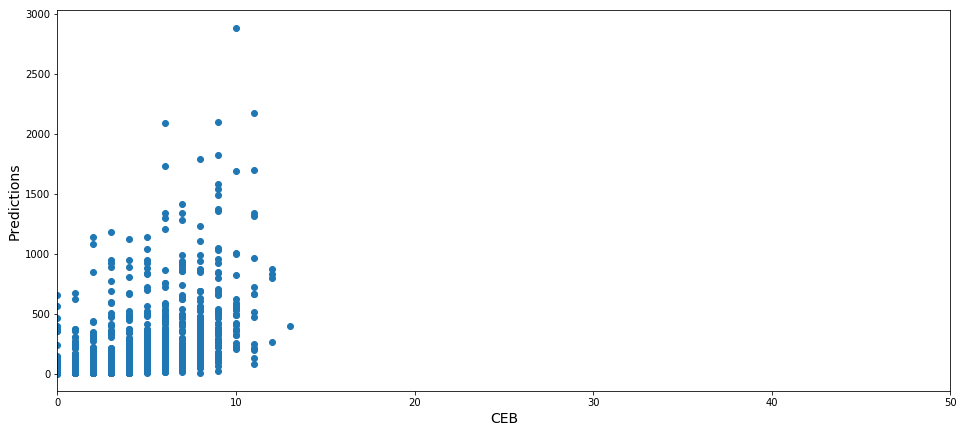

In [46]:
plt.figure(figsize(16,7))
scatter(botswana['ceb'], np.exp(fitted_m4.fittedvalues))
plt.xlabel('CEB', fontsize=14)
plt.ylabel('Predictions', fontsize=14)
plt.xlim([0,50])

With the attractiveness factors of interest to us, the coefficients are -0.1307 (below average) and -0.0010 (above average).

Since the regression was done on the logarithm of the response, they can be interpreted as a percentage increase. Taking into account additional factors, representatives of the general population from which the sample is taken, get on average:

* 13% less if their attractiveness is below average (p = 0.001, 95% confidence interval - [5.21]%);
* the same if their attractiveness is above average (p = 0.972, 95% confidence interval - [-6.6]%).